In [60]:
using Distributions,CSV,DataFrames,StatsPlots,Turing
using ExponentialAnalysis
default(size=(700,300))

# テレビCMの露出をPPLで表現する
- GRPは接触人数である。ある母集団から一定割合の人を選んで戻す、という試行を繰り返すことと等しい。
- したがって視聴率分の試行を連続して行う幾何分布であるといえる。
- しかし幾何分布の場合、pとして与えられるパラメータはひとつの定数である。これに対してGRP投下はpが連続して変化する。
- まずはこのようにpが変化する（一本ずつの視聴率が異なる）GRP投下をPPLで表現する方法を明らかにする

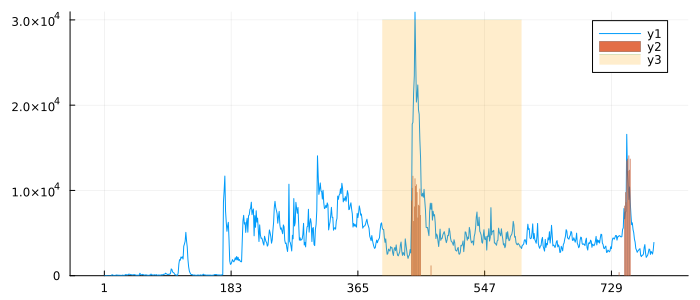

In [2]:
cc_df = CSV.read("data/CCHANNEL_DL_TV.csv", DataFrame)
@df cc_df[:,:] plot(:TTL, xticks=1:182:364*3)
@df cc_df[:,:] bar!(:GRP .* 1e2, lw=0)
plot!(400:600, x->3e4, fill=(0, 0.2, :orange), lw=0)

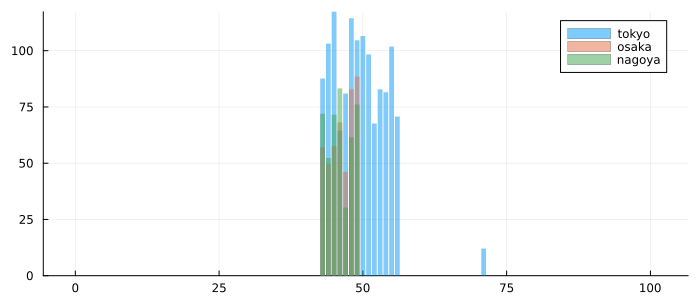

In [3]:
cc3 = CSV.read("data/CCHANNEL_DL_3AREA_400-500.csv", DataFrame)
@df cc3 bar([:GRPT, :GRPO, :GRPN] ,lw=0, alpha=0.5)
ccdl= cc3[:,:TTL] ;
mccgrp=  cc3[:,[:GRPT, :GRPO, :GRPN]] |> Matrix
ms = [43_000_000 , 20_000_000, 10_000_000];
bar(mccgrp, lw=0, alpha=0.5, label=["tokyo" "osaka" "nagoya"])

In [4]:
mod = expmodel(ccdl, mccgrp, ms)

DynamicPPL.Model{typeof(ExponentialAnalysis.expdecompose), (:dl, :grp, :ms), (:K,), (), Tuple{Vector{Int64}, Matrix{Float64}, Vector{Int64}}, Tuple{Int64}, DynamicPPL.DefaultContext}(ExponentialAnalysis.expdecompose, (dl = [5594, 5414, 5415, 4457, 3914, 4320, 3208, 2507, 2600, 3120  …  4775, 4229, 3877, 4180, 4731, 4693, 5562, 5186, 4419, 4039], grp = [0.0 0.0 0.0; 0.0 0.0 0.0; … ; 0.0 0.0 0.0; 0.0 0.0 0.0], ms = [43000000, 20000000, 10000000]), (K = 2,), DynamicPPL.DefaultContext())

In [5]:
ps, chain = analysis(mod)

┌ Info: Found initial step size
│   ϵ = 9.313225746154786e-11
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


((ys = [1.7387734142901665, 39.59154402494874], w = [0.5275918730637934, 0.47240812693620654], r = [0.00017964012809157807, 5.8632846890611855e-6], s = 593.8937724119273), MCMC chain (2000×19×1 Array{Float64, 3}))

In [6]:
cc_eff, lb = describe_effect(ccdl, mccgrp, ms, ps)

([1873.437077104192 0.0 0.0; 1873.437077104192 0.0 0.0; … ; 1873.437077104192 7.105132615851588e-5 1107.7284002114127; 1873.437077104192 3.997620826356336e-5 1080.0998746827838;;; 871.3660823740428 0.0 0.0; 871.3660823740428 0.0 0.0; … ; 871.3660823740428 1.51261008223017e-9 164.43611654416046; 871.3660823740428 8.506442343522076e-10 160.33481568114973;;; 435.6830411870214 0.0 0.0; 435.6830411870214 0.0 0.0; … ; 435.6830411870214 6.474960860028796e-10 80.95577522953609; 435.6830411870214 3.640966023893684e-10 78.9366081645841], ["recog_base" "short_grp_effect" "long_grp_effect"])

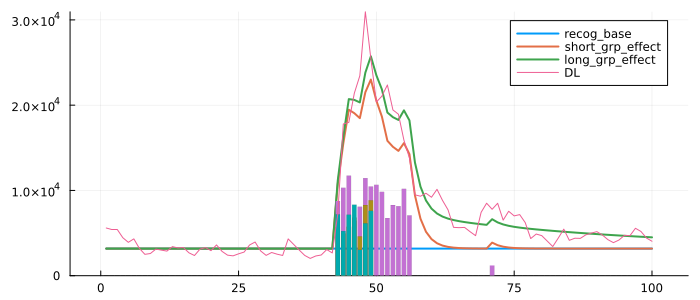

In [7]:
cc_eff_mat = sum(cc_eff,dims=3) |> t-> accumulate(+, t, dims=2) |> t->reshape(t, :, 3) 
plot(cc_eff_mat , label=lb,lw=2)
bar!(mccgrp .* 100, lw=0,label="")
plot!(ccdl,label="DL")

mdist = MixtureModel([Exponential(y) for y = ps.ys], ps.w) = MixtureModel{Exponential{Float64}}(K = 2)
components[1] (prior = 0.5276): Exponential{Float64}(θ=1.7387734142901665)
components[2] (prior = 0.4724): Exponential{Float64}(θ=39.59154402494874)



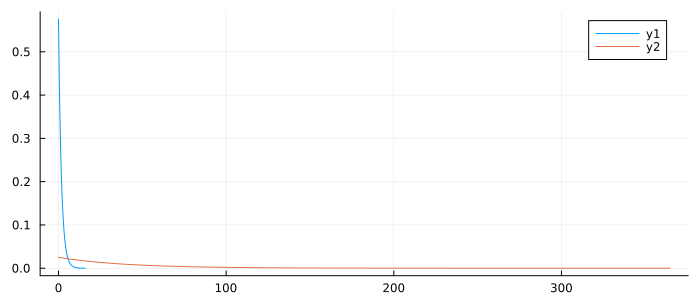

In [8]:
@show mdist = MixtureModel([Exponential(y) for y in ps.ys], ps.w)
plot(mdist)

In [9]:
inference_recognition(ccdl[1:40])

┌ Info: Found initial step size
│   ϵ = 1.4901161193847657e-9
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


(0.09099062677227518, (r = 15.450666596849523, p = 0.004807955867232927, th = 206.9885979850975, recog = 0.09099062677227518, s = 302.5867128294185))

In [10]:
inference_recognition(ccdl[75:100])

┌ Info: Found initial step size
│   ϵ = 2.9802322387695314e-9
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


(0.20390494052788122, (r = 26.09443253757708, p = 0.005382747908407343, th = 184.77871693342627, recog = 0.20390494052788122, s = 262.411255980577))

# 別のデータ　DELISH KITCHEN

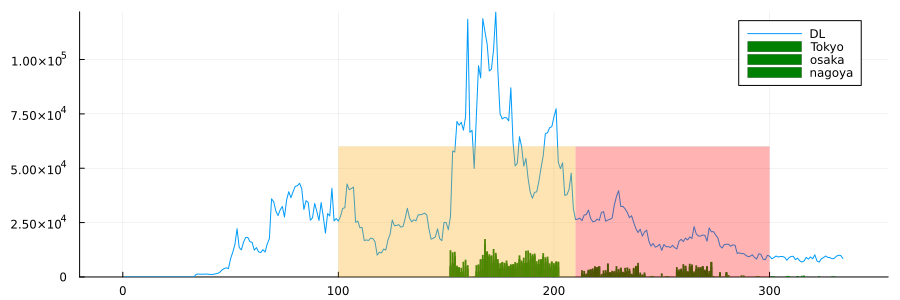

In [13]:
dk =CSV.read("data/Delish_kitchen_dl_tv_ton.csv",DataFrame);
@df dk plot(:TTL,label="DL",size=(900,300))
@df dk bar!([:GRPT, :GRPO, :GRPN] .* 1e2, label=["Tokyo" "osaka" "nagoya"],lw=0, c=:green)
plot!(100:210, x->6e4,fill=(0,0.3, :orange),lw=0,label="")
plot!(210:300, x->6e4,fill=(0,0.3, :red),lw=0,label="")
#plot!(100:150, x->6e4,fill=(0,0.3, :red),lw=0,label="")

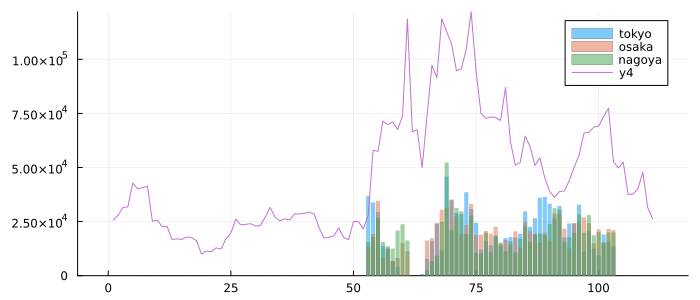

In [14]:
dkdl= dk[100:210,:TTL] ;
mdkgrp=  dk[100:210,[:GRPT, :GRPO, :GRPN]] |> Matrix
ms = [43_000_000 , 20_000_000, 10_000_000];
bar(mdkgrp .* 300, lw=0, alpha=0.5, label=["tokyo" "osaka" "nagoya"])
plot!(dkdl)

In [15]:
model=expmodel(dkdl, mdkgrp, ms)
dkps, dk_chain =analysis(model)

┌ Info: Found initial step size
│   ϵ = 9.313225746154786e-11
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


((ys = [2.2264770821900024, 1.5218697191731603], w = [0.5848168617531327, 0.41518313824686726], r = [0.001061536959859683, 8.1418243828952e-6], s = 3381.9129186467844), MCMC chain (2000×19×1 Array{Float64, 3}))

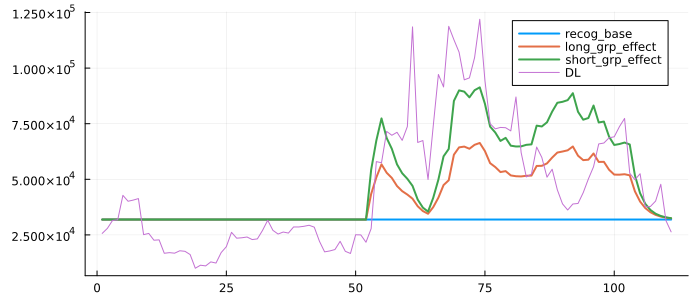

In [21]:
dk_effect, dk_lb = describe_effect(dkdl, mdkgrp, ms, dkps)
dk_eff_mat = sum(dk_effect,dims=3) |> t-> accumulate(+, t, dims=2) |> t->reshape(t, :, 3) 
plot(dk_eff_mat, label=dk_lb,lw=2)
plot!(dkdl, label="DL")
#bar!(mdkgrp .* 100, lw=0,legend=false)

mdist = MixtureModel{Exponential{Float64}}(K = 2)
components[1] (prior = 0.5848): Exponential{Float64}(θ=2.2264770821900024)
components[2] (prior = 0.4152): Exponential{Float64}(θ=1.5218697191731603)



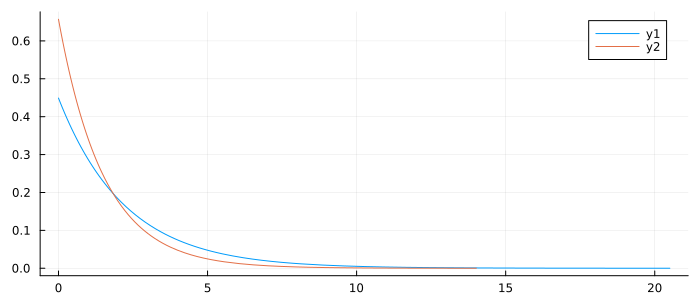

In [22]:
mdist = MixtureModel([Exponential(y) for y in dkps.ys], dkps.w)
@show mdist ;plot(mdist)

In [25]:
ir, _=inference_recognition(dk[100:150, :TTL])
ir2, _=inference_recognition(dk[300:end, :TTL])
ir, ir2

┌ Info: Found initial step size
│   ϵ = 1.4901161193847657e-9
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192
┌ Info: Found initial step size
│   ϵ = 7.450580596923829e-10
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


(0.8927670063948159, 0.6520431596544704)

### Other case; Brave Frontier

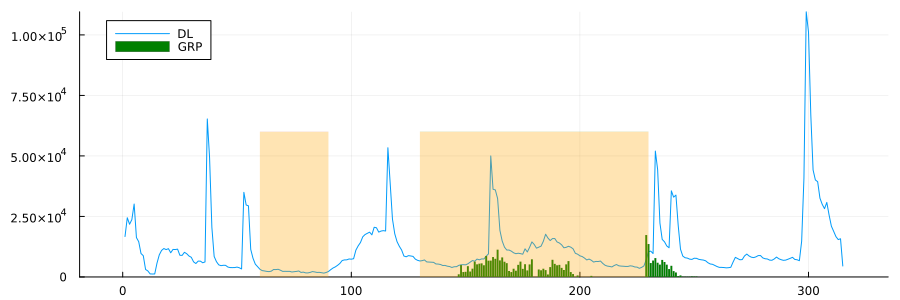

In [33]:
bf = CSV.read("data/BRAFRO_DL_GRP.csv",DataFrame)  
@df bf plot(:TTL,label="DL",size=(900,300))
@df bf bar!(:GRP .* 1e2, label="GRP",lw=0, c=:green)
plot!(130:220, x->6e4,fill=(0,0.3, :orange),lw=0,label="")
plot!(60:90, x->6e4,fill=(0,0.3, :orange),lw=0,label="")

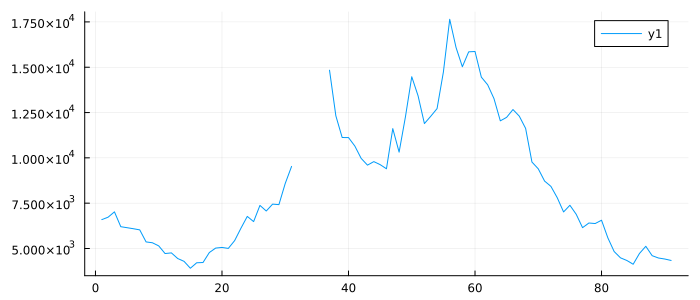

In [29]:
bfdl =bf[130:220,:TTL] |> t->[i in 32:36 ? missing : t[i] for i =1:length(t)]
bfgrp =bf[130:220, :GRP];
bfmgrp = bf[130:220, [:GRP_TOKYO, :GRP_OSAKA, :GRP_NAGOYA]] |> Matrix ;

plot(bfdl)

In [30]:
model=expmodel(bfdl, bfmgrp, ms)
bfps, bf_chain =analysis(model)

┌ Info: Found initial step size
│   ϵ = 7.450580596923829e-10
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


((ys = [0.7459323558673604, 15.069692285309102], w = [0.1219152825819118, 0.8780847174180881], r = [0.0003821248177768369, 2.4957691966847575e-6], s = 630.5535319428087), MCMC chain (2000×19×1 Array{Float64, 3}))

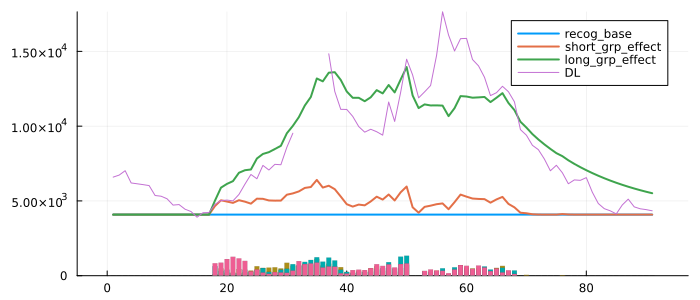

In [37]:
bf_effect, bf_lb = describe_effect(bfdl, bfmgrp, ms, bfps)
bf_effect_mat = sum(bf_effect, dims=3) |> t-> accumulate(+, t, dims=2) |> t->reshape(t, :, 3) 
plot(bf_effect_mat, label=bf_lb,lw=2)
plot!(bfdl, label="DL")
bar!(bfmgrp .* 1e1, lw=0, label="")

mdist = MixtureModel{Exponential{Float64}}(K = 2)
components[1] (prior = 0.1219): Exponential{Float64}(θ=2.2264770821900024)
components[2] (prior = 0.8781): Exponential{Float64}(θ=1.5218697191731603)



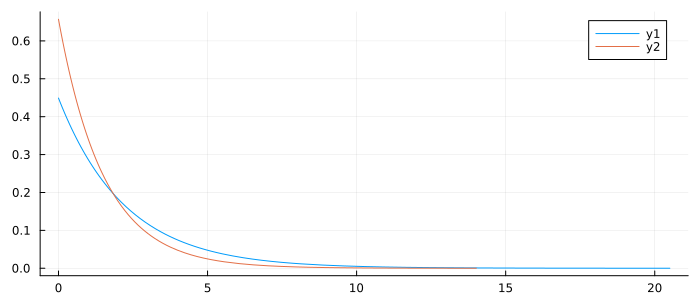

In [38]:
mdist = MixtureModel([Exponential(y) for y in dkps.ys], bfps.w)
@show mdist ;plot(mdist)

## Other case; KURASHIRU

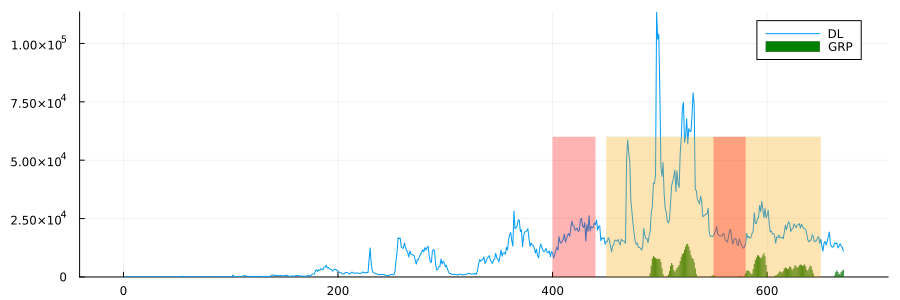

In [39]:
kr = CSV.read("data/KURASHIRU_GRP_DL.csv",DataFrame)  
@df kr plot(:TTL,label="DL",size=(900,300))
@df kr bar!(:GRP .* 1e2, label="GRP",lw=0, c=:green)
plot!(450:650, x->6e4,fill=(0,0.3, :orange),lw=0,label="")
plot!(550:580, x->6e4,fill=(0,0.3, :red),lw=0,label="")
plot!(400:440, x->6e4,fill=(0,0.3, :red),lw=0,label="")

In [44]:
krdl = kr[450:580,:TTL] |> t->[i in 20:25 || i in 48:51 ? missing : t[i] for i =1:length(t)];
krgrp = kr[450:580,:GRP] ;

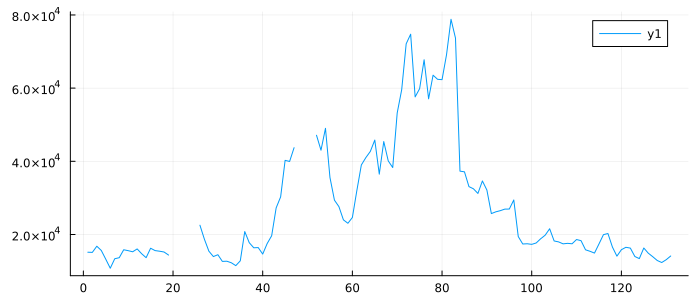

In [45]:
plot(kr_dl)

In [52]:
model=expmodel(krdl, krgrp, 120_000_000)
krps, kr_chain =analysis(model)

┌ Info: Found initial step size
│   ϵ = 4.656612873077393e-11
└ @ Turing.Inference /Users/kimseok/.julia/packages/Turing/UCuzt/src/mcmc/hmc.jl:192


((ys = [8.487507366765763, 0.14554980171967885], w = [0.6584715364928088, 0.3415284635071913], r = [0.0003118915702926922, 4.7146342949626324e-6], s = 1497.0510313559944), MCMC chain (2000×19×1 Array{Float64, 3}))

In [61]:
kr_effect, kr_lb = describe_effect(krdl, krgrp, 120_000_000, krps)
kr_effect_mat = accumulate(+, kr_effect, dims=2) #|> t->reshape(t, :, 3) 
plot(kr_effect_mat, label=kr_lb,lw=2)
plot!(krdl, label="DL")
bar!(krgrp .* 1e1, lw=0, label="")

MethodError: MethodError: no method matching describe_effect(::Vector{Union{Missing, Int64}}, ::Vector{Float64}, ::Int64, ::NamedTuple{(:ys, :w, :r, :s), Tuple{Vector{Float64}, Vector{Float64}, Vector{Float64}, Float64}})

Closest candidates are:
  describe_effect(::Vector, !Matched::Matrix, !Matched::Vector, ::Any)
   @ ExponentialAnalysis ~/GitHub/ExponentialAnalysis.jl/src/ExponentialAnalysis.jl:101


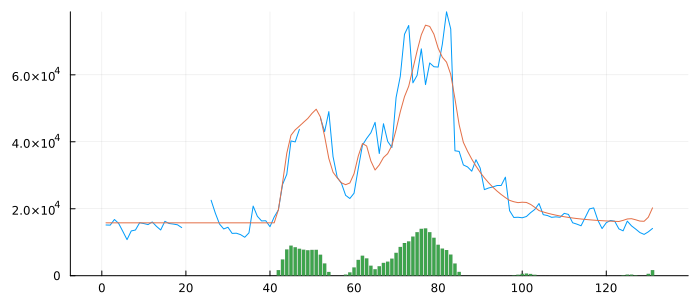

In [75]:
rs,rz= describers2(kr_dl, kr_grp, krps)
plot([kr_dl, rs])
bar!(kr_grp .* 100, lw=0,legend=false)

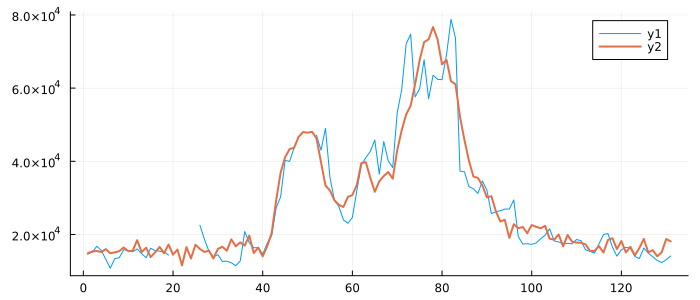

In [76]:
plot(kr_dl) ; plot!(rz, lw=2)

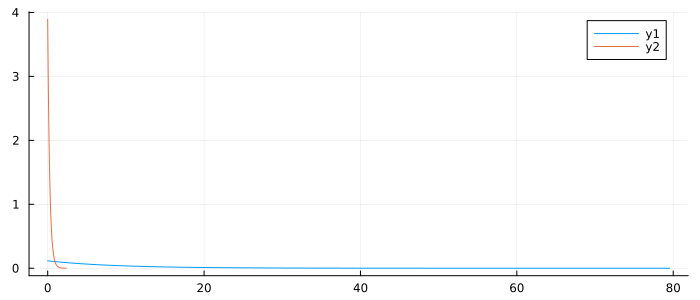

In [77]:
mdist = MixtureModel([Exponential(y) for y in krps.ys], krps.w)
plot(mdist)

In [78]:
ir1=inference_recognition(kr_dl[1:40])
ir2=inference_recognition(kr_dl[100:end])
ir1.recog,ir2.recog

┌ Info: Found initial step size
└   ϵ = 5.960464477539063e-9
┌ Info: Found initial step size
└   ϵ = 5.960464477539063e-9


(0.9493687520705095, 0.951869057020418)

In [79]:
gmdist(r) = MixtureModel([Gamma(r, y/r) for y in krps.ys], krps.w)

gmdist (generic function with 1 method)

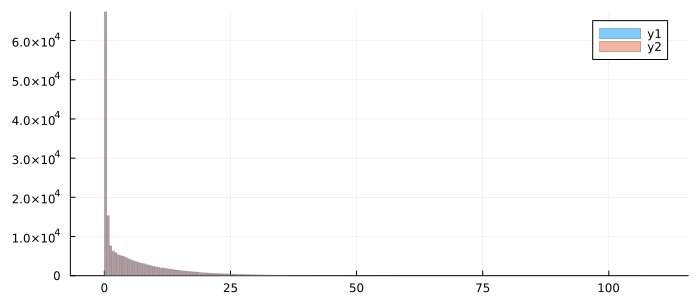

In [80]:
histogram(rand(gmdist(1),200000), alpha=0.5, lw=0)
histogram!(rand(mdist, 200000),alpha=0.5, lw=0)

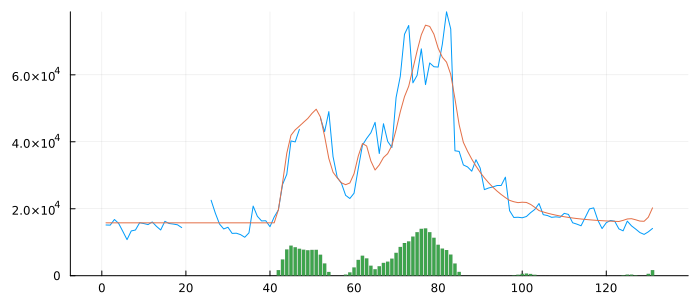

In [81]:
plot([kr_dl, rs])
bar!(kr_grp .* 100, lw=0,legend=false)

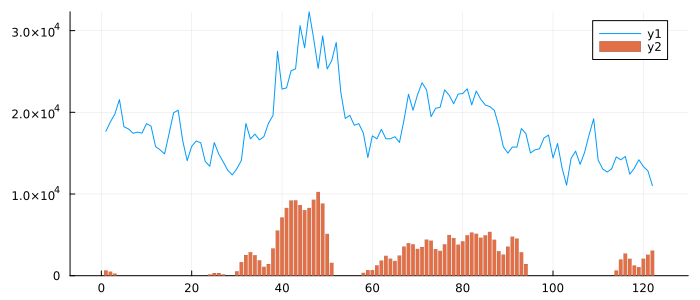

In [82]:
kr_dl2 = kr[550:end,:TTL] #|> t->[i in 20:25 || i in 48:51 ? missing : t[i] for i =1:length(t)];
kr_grp2 = kr[550:end,:GRP] ;
plot(kr_dl2)
bar!(kr_grp2 .* 100, lw=0)

In [83]:
model=expdecompose2(kr_dl2, kr_grp2 ; K=2)
krc2=sample(model, NUTS(.65), 2000)

┌ Info: Found initial step size
└   ϵ = 5.820766091346741e-12
Sampling: 100%|█████████████████████████████████████████| Time: 0:05:20


Chains MCMC chain (2000×19×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 324.39 seconds
Compute duration  = 324.39 seconds
parameters        = s, r[1], r[2], w[1], w[2], ys[1], ys[2]
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters          mean          std        mcse   ess_bulk   ess_tail      ⋯
      Symbol       Float64      Float64     Float64    Float64    Float64   Fl ⋯

           s      904.4796      16.1613      1.1434   211.3322   352.1011    1 ⋯
        r[1]     2097.0116     112.5656     18.4306    40.3047    39.5832    1 ⋯
        r[2]   794591.8680   19529.3653   1039.9417   334.5718   504.6042    1 ⋯
        w[1]        0.8842       0.1501      0.0374    19.0426    45.7031    1 ⋯
        w[2]        0.1158    

In [84]:
krps2= get(krc2, [:r, :w, :ys, :s]) |> t-> (;  ys=[mean(e) for e in t.ys], 
      w=[mean(e) for e in t.w], r=[1/mean(e) for e in t.r], s=mean(t.s))

(ys = [3.219309620842557, 27.018784779320335], w = [0.8842379717073509, 0.11576202829264907], r = [0.00047686908774372693, 1.2585077198860128e-6], s = 904.479562237868)

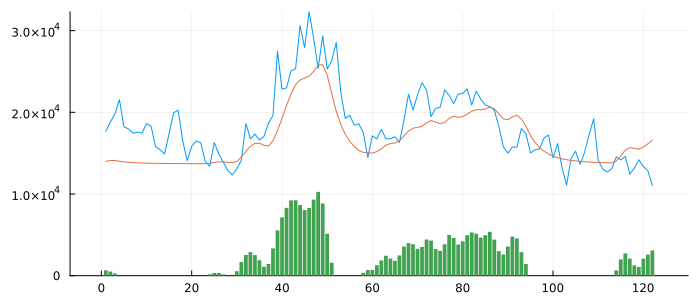

In [85]:
rs,rz= describers2(kr_dl2, kr_grp2, krps2)
plot([kr_dl2, rs])
bar!(kr_grp2 .* 100, lw=0,legend=false)

mdist2 = MixtureModel{Exponential{Float64}}(K = 2)
components[1] (prior = 0.8842): Exponential{Float64}(θ=3.219309620842557)
components[2] (prior = 0.1158): Exponential{Float64}(θ=27.018784779320335)



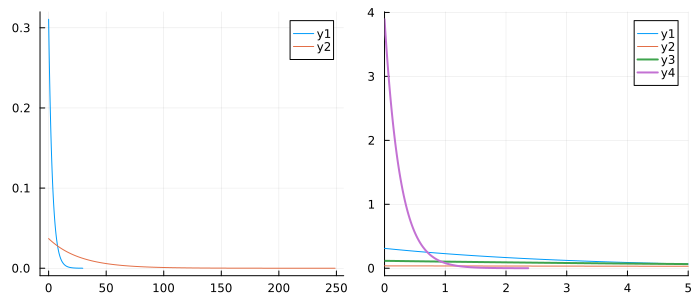

In [86]:
mdist2 = MixtureModel([Exponential(y) for y in krps2.ys], krps2.w)
@show mdist2
pl1=plot(mdist2)
pl2=plot(mdist2) ; plot!(pl2,mdist, lw=2 ,xlims=(0,5))
plot(pl1,pl2)

# 大量のCM認知者によって行動DLが誘発される　DLまでの時間を知りたい。

In [87]:
recog_action(m, rg, dtime) = m * rg * cdf(Exponential(dtime), 1.0)
grp_action(u, grp_array, dtime ,i) = [u * grp_array[k] *( cdf(Exponential(dtime), i-k+1) - cdf(Exponential(dtime), i-k) ) for k = 1:i] |> sum

grp_action (generic function with 1 method)

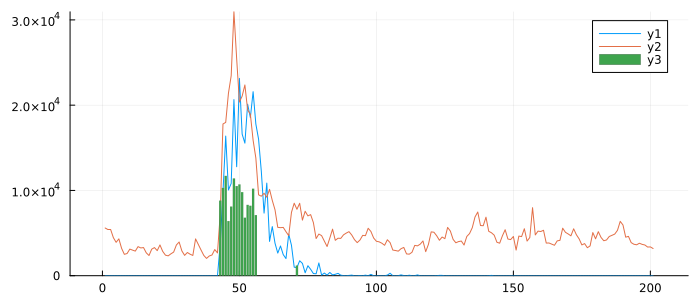

In [88]:
m = 120_000_000
cc_grn = (cc_grp ./100 )./ mean(tbbeta) |> t->round.(t)
ac_grn = accumulate(+, cc_grn) |> t-> [cc_grn[i] == 0 ? 0 : ac_grn[i] for i = 1:length(cc_grn)]

precm_recog = 0.1
tgamma = Gamma(23.7,179)
#rand_exp(;n=120_000_000) = rand(tgamma) |> t-> n * cdf(Exponential(t),1)
dl = [recog_action(m, precm_recog, rand(tgamma)) for i = 1:length(cc_grp)]
dl_tv = [grp_action(m*0.0002, cc_grp ./ 100, rand(Gamma(5, 1.22 )), i) for i = 1:length(cc_grp)]
test_dl =  dl_tv  #.+ dl
plot([test_dl , cc_dl])
bar!(cc_grp .* 100, lw=0)

In [89]:
@model function expaction(m, dl, delay)
    recog ~  truncated(TDist(3), 0.00001, 0.99999)
    s ~ Exponential(1)
    dl ~ Normal( m * recog * cdf(Exponential(delay), 1.0), s)
    return recog
end

expaction (generic function with 2 methods)

In [90]:
#grp_nbaction(u, grp_array, nb ,i) = [u * grp_array[k] *( cdf(nb, i-k+1) - cdf(nb, i-k) ) for k = 1:i] |> sum
integrate_grp(m, grp, rn) =  ( sum( m .* grp) - rn) / m 
@model function delayedarrival(dl, grp , basedist ; n = length(dl), m =120_000_000, J=43)
    rg ~ truncated(TDist(3), 0.00001, 0.5)
    #k ~ truncated(TDist(3), 0.00001, 0.5)
    
    #Gamma dist
    r ~ InverseGamma(2,3)
    th ~ truncated(TDist(3), 0.001, 0.999)
    s ~ InverseGamma(2,3)
    for i = 1:J-1  
        g ~ Gamma(basedist.α, basedist.θ)
        r1 = recog_action(m, rg, g)
        dl[i] ~ Normal( r1 , s)
    end
    
    for i = J:n
        y = mean(grp[1:J-1])
        k = integrate_grp(m, grp, y*n)
        
        d ~ Gamma(r, 1/th)
        r2 = grp_action( m * k , cc_grp, d , i)
        
        dl[i] ~ Normal( y + r2 , s)        
    end
end

delayedarrival (generic function with 2 methods)

In [91]:
cdf(NegativeBinomial(12,0.6), 1),cdf(NegativeBinomial(12,0.6), 2)

(0.01262533754879999, 0.03979158110207997)

In [92]:
model = delayedarrival(test_dl, cc_grp ./100 , tgamma)
c_dl = sample(model, NUTS(0.65), 2000)

┌ Info: Found initial step size
└   ϵ = 1.1641532182693482e-11
Sampling: 100%|█████████████████████████████████████████| Time: 1:02:42


Chains MCMC chain (2000×18×1 Array{Float64, 3}):

Iterations        = 1001:1:3000
Number of chains  = 1
Samples per chain = 2000
Wall duration     = 3771.83 seconds
Compute duration  = 3771.83 seconds
parameters        = rg, r, th, s, g, d
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters             mean             std            mcse   ess_bulk   ess ⋯
      Symbol          Float64         Float64         Float64    Float64    Fl ⋯

          rg           0.4145          0.0001          0.0000     7.3421    21 ⋯
           r    93266788.4501   15614850.9390    6870875.8487     7.1407    15 ⋯
          th           0.2007          0.0001          0.0000     7.1823    24 ⋯
           s        7703.8886        987.5575        427.2306     5.6600    15 ⋯
           g        4424.9793          4.9724    

In [93]:
ps = get(c_dl, [:rg, :th, :r]) |> t-> (; r = mean(t.r), th= 100/ mean(t.th), rg = mean(t.rg) )
#ps = get(c_dl, [:rg ]) |> t-> (;rg = mean(t.rg) )

(r = 9.326678845007907e7, th = 498.23667579115573, rg = 0.4145254601139351)

In [94]:
rs = zeros(length(cc_grp))
m = 120_000_000
for i = 1:length(rs)
    dl, dl_tv = 0, 0
    dl    = recog_action(m, ps.rg, rand(tgamma)) 
    
    y = mean(grp[1:42])
     k = integrate_grp(m, grp, y*43)
    dl_tv = grp_action(m * k, cc_grp ./ 100, rand(Gamma(ps.r, ps.th)), i)
    rs[i] = dl + dl_tv
end

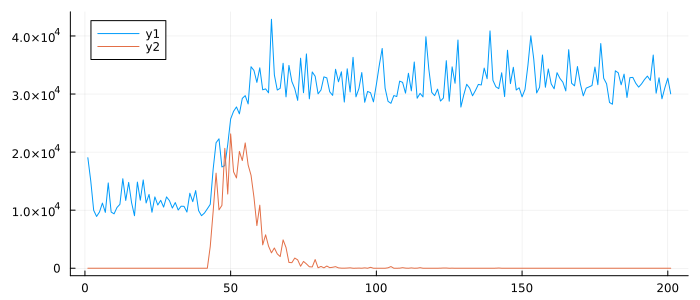

In [95]:
plot([rs, test_dl])

In [96]:
@model function expaction(cc_dl, tdist ; n = length(dl))
    fq ~ Poisson(4)
    λ ~ InverseGamma(2,3)
    reach = reach_func(fq)
    s ~ Exponential(1)
    for i = 1:n
        
        ys = dl[i] + sum_ta(m, reach, Exponential(4), i)
        cc_dl[i] ~ Normal(ys,s)
    end
end
    

expaction (generic function with 4 methods)

In [97]:
model = expaction(cc_dl)
c = sample(model, NUTS(.65), 2000, proress=false)

LoadError: MethodError: no method matching expaction(::Vector{Int64})

[0mClosest candidates are:
[0m  expaction(::Any, [91m::Any[39m; n)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[96]:1[24m[39m
[0m  expaction(::Any, [91m::Any[39m, [91m::Any[39m)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[89]:1[24m[39m
[0m  expaction([91m::DynamicPPL.Model[39m, [91m::DynamicPPL.AbstractVarInfo[39m, [91m::AbstractPPL.AbstractContext[39m, [91m::Any[39m, [91m::Any[39m; n)
[0m[90m   @[39m [35mMain[39m [90m[4mIn[96]:1[24m[39m
[0m  ...


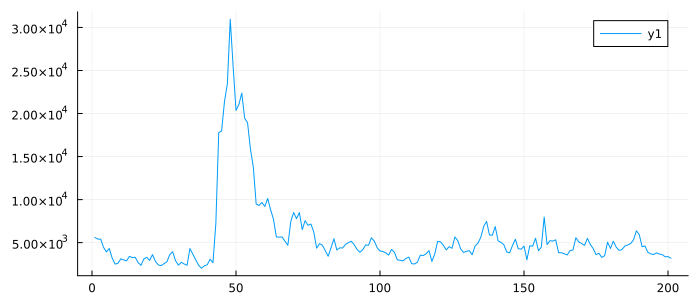

In [98]:
plot(cc_dl )

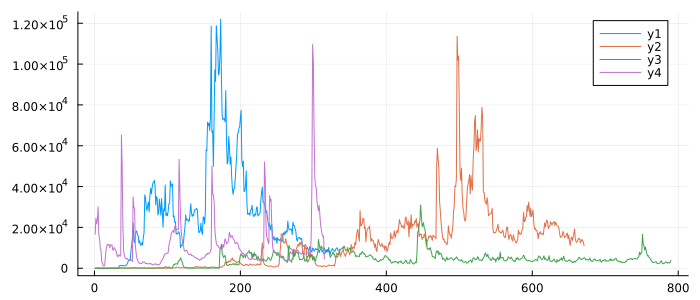

In [99]:
plot([dk[:,:TTL], kr[:,:TTL], cc_df[:,:TTL], bf[:,:TTL]])

In [100]:
ir=inference_recognition(kr[400:500,:TTL])
ir.recog

┌ Info: Found initial step size
└   ϵ = 4.76837158203125e-8


0.8462098650318711

In [101]:
ir=inference_recognition(dk[50:60, :TTL])
ir.recog

┌ Info: Found initial step size
└   ϵ = 4.76837158203125e-8


0.9091938729654182